In [5]:
import sys
sys.path.insert(0, "/home/matheus/projects/marioai")

from marioai.core import Runner, Task
from marioai.agents import BaseAgent, ExploratoryAgent
import pandas as pd
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

In [18]:
class State():
    def __init__(self, **kwargs):
        self.state_attrs = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.state_attrs.append(key)
    
    def __repr__(self):
        repr_str = "State("
        for attr in self.state_attrs:
            repr_str += f"{attr}={getattr(self, attr)}, "
        return repr_str
    def __hash__(self):
        attrs = []
        for attr in self.state_attrs:
            attrs.append(attr)
        return hash(tuple(attrs))

    def __eq__(self, other):
        for attr in self.state_attrs:
            if getattr(self, attr) != getattr(other, attr):
                return False
        return True
        
class MonteCarloAgent(BaseAgent):

    def __init__(
        self, 
        n_samples, 
        discount, 
        min_epsilon=0.3, 
        reward_threshold=0, 
        reward_increment=0.5):

        super().__init__()
        self.n_samples = n_samples
        self.discount = discount
        self.in_fit = False
        self.min_epsilon = min_epsilon
        self.reward_threshold = reward_threshold
        self.reward_increment = reward_increment
        self.epsilon = 1
        self.policy_kind = "greedy"
        self.value_func = {}
        self._N = {}
        self._S = {}
        self._Q = {}
        self.actions_idx = []
        self.fit_rewards = []
        self.actual_x = 0

    def reset(self):
        self.actual_x = 0
        self.states = []
        self.rewards =  []
        self.actions = []
        self.actions_idx = []
        
    def compute_reward(self, reward_data):
        if reward_data["status"] == 1:
            return reward_data["distance"] * 2
        if "distance" in reward_data:
            return reward_data["distance"] * 0.1
        dist = self.mario_floats[0] - self.actual_x
        self.actual_x = self.mario_floats[0]
        return dist * 0.01

    def policy(self, state):
        """This function compute the policy"""
        if self.policy_kind == "random":
            action_idx = np.random.randint(self._Q[state].shape[0])
        elif self.policy_kind == "greedy":
            action_idx = self._Q[state].argmax()
        elif self.policy_kind == "e_greedy":
            if np.random.random() > self.epsilon:
                action_idx = self._Q[state].argmax()
            else:
                action_idx = np.random.randint(self._Q[state].shape[0])
        self.actions_idx.append(action_idx)
        return action_idx

    def filter_actions(self) -> np.array:
        """This function filter the action pool"""
        action_pool = np.copy(self._action_pool)
        return action_pool

    def act(self):
        action_pool = self.filter_actions()
        state = State(**self.state)
        if state not in self._Q:
            self._Q[state] = np.zeros(action_pool.shape[0])
        action_idx = self.policy(state)
        action = action_pool[action_idx].tolist()
        self.actions.append(action)
        return action

    def fit(self, task: Task, **runner_kwargs):
        self.in_fit = True
        self._action_pool = task._action_pool
        self.policy_kind = "e_greedy"
        runner = Runner(self, task, **runner_kwargs)
        self.epsilon = 1.
        for k in (pbar :=tqdm(range(self.n_samples), total=self.n_samples)):
            # Run sample
            runner.run()
            # Update model
            self.fit_rewards.append(self._step())
            # Update epsilon
            if self.epsilon > self.min_epsilon and self.fit_rewards[-1] >= self.reward_threshold:  
                epsilon_delta = 1/(self.n_samples)  
                #epsilon_delta = 0.1
                self.epsilon = self.epsilon - epsilon_delta  
                self.reward_threshold = self.reward_threshold + self.reward_increment
            pbar.set_description(f"Last Reward {self.fit_rewards[-1]:.2f} Epsilon: {self.epsilon:.3f} Reward Th: {self.reward_threshold: .3f}")
            pbar.refresh()

        runner.close()
        self.in_fit = False
        self.policy_kind = "greedy"
        return self

    

    def _step(self):
        # Compute all rewards
        rewards = np.array(list(map(self.compute_reward, self.rewards)))
        prev_Q = deepcopy(self._Q)
        for i, (state_dict, action) in enumerate(zip(self.states, self.actions_idx)):
            state = State(**state_dict)
            # Increment counter
            if state not in self._N:
               self._N[state] = np.zeros(self._Q[state].shape[0])
            self._N[state][action] += 1

            # Compute Gt
            future_rewards = rewards[i:]
            discounts = np.array([self.epsilon ** k for k in range(future_rewards.shape[0])])
            g_t = np.dot(discounts, future_rewards)/self.n_samples

            # Update Q(s,a)
            q_value = self._Q[state][action]
            self._Q[state][action] = q_value + (1/self._N[state][action])*(g_t - q_value)

        return rewards.sum()

In [19]:
task = Task()
mc_model = MonteCarloAgent(100, 0.9, state_max_dist=4, min_epsilon=0.3, reward_threshold=2, reward_increment=0.5)
mc_model = mc_model.fit(task=task, level_difficult=0, mario_mode=0, time_limit=100, response_delay=0, max_fps=720)

/home/matheus/projects/marioai/notebooks
Connection attempt: 1/5
Connection attempt: 2/5
Connection attempt: 3/5


TypeError: __init__() got an unexpected keyword argument 'max_dist'

In [23]:
pd.DataFrame(mc_model.states)

,region_x,episode_starts,on_ground,can_jump,episode_over,soft_1,soft_2,soft_3,soft_4,hard_1,...,brick_3,brick_4,projetil_1,projetil_2,projetil_3,projetil_4,has_role_near_1,has_role_near_2,has_role_near_3,has_role_near_4
0,0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
1,0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
2,0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
3,0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
4,0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,0,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1497,0,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1498,0,True,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1499,0,True,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True


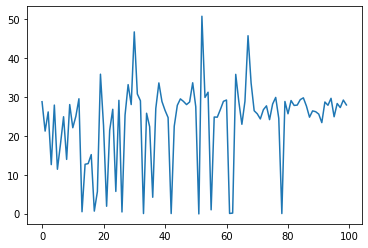

In [43]:

plt.plot(range(len(mc_model.fit_rewards)), mc_model.fit_rewards)

In [3]:
agent = BaseAgent()
runner = Runner(agent, level_difficult=0, mario_mode=1, time_limit=100, response_delay=0, max_fps=24)
runner.run()
runner.close()

/home/matheus/projects/marioai/notebooks
Connection attempt: 1/5
Connection attempt: 2/5
Connection attempt: 3/5


<AxesSubplot:>

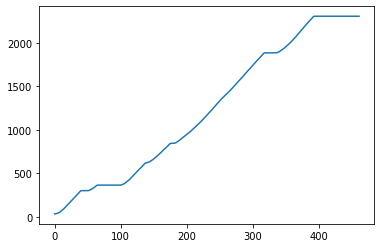

In [5]:
states = pd.DataFrame(agent.states)
states.x.plot()

In [6]:
states.x//500

0      0
1      0
2      0
3      0
4      0
      ..
457    4
458    4
459    4
460    4
461    4
Name: x, Length: 462, dtype: int64